In [16]:
import re
import pandas as pd
from collections import Counter
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack  # To combine sparse and dense matrices
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


In [17]:
# Define suspicious words and URL shorteners
SUSPICIOUS_WORDS = ['login', 'signin', 'bank', 'update', 'verify', 'secure', 'account', 'password', 'confirm', 'free']
URL_SHORTENERS = ['bit.ly', 'tinyurl.com', 'goo.gl', 'is.gd', 't.co']

def calculate_entropy(url):
    """Calculate Shannon entropy of a URL."""
    p, lns = Counter(url), float(len(url))
    return -sum(count / lns * math.log2(count / lns) for count in p.values())

def extract_features(url):
    """Extract manual features from a URL."""
    domain = re.findall(r'://([^/]+)', url)
    domain = domain[0] if domain else ''
    return {
        'url_length': len(url),
        'num_digits': len(re.findall(r'\d', url)),
        'num_special_chars': len(re.findall(r'[!@#$%^&*(),.?":{}|<>]', url)),
        'num_subdomains': url.count('.') - 1,
        'contains_https': int('https' in url),
        'contains_ip': int(bool(re.match(r'^(?:\d{1,3}\.){3}\d{1,3}', url))),
        'has_suspicious_words': int(any(word in url.lower() for word in SUSPICIOUS_WORDS)),
        'is_shortened_url': int(any(shortener in url for shortener in URL_SHORTENERS)),
        'url_entropy': calculate_entropy(url),
        'num_params': url.count('&') + url.count('?'),
        '0s_in_url': url.count('0'),
        'domain_length': len(domain)
    }


In [18]:
# Load dataset
file_path = './data/phishing_site_urls.csv'  # Change path as needed
df = pd.read_csv(file_path)
sampled_df = df.sample(frac=0.25, random_state=42)

# Extract manual features
sampled_df = pd.DataFrame(df['URL'].apply(lambda x: extract_features(x)).tolist())
sampled_df['Label'] = df['Label'].map({'good': 0, 'bad': 1})  # Encode labels

# Drop rows with missing values
sampled_df.dropna(inplace=True)

# Align original dataset with filtered rows
df_aligned = df.loc[sampled_df.index]

print("Data Loaded and Features Extracted")
sampled_df.head()


Data Loaded and Features Extracted


,url_length,num_digits,num_special_chars,num_subdomains,contains_https,contains_ip,has_suspicious_words,is_shortened_url,url_entropy,num_params,0s_in_url,domain_length,Label
0,225,58,10,5,0,0,1,0,5.026886,4,8,0,1.0
1,81,1,6,4,0,0,0,0,4.686883,1,0,0,1.0
2,177,47,7,6,0,0,1,0,4.721044,0,0,0,1.0
3,60,0,6,5,0,0,0,0,4.079842,0,0,0,1.0
4,116,21,2,0,0,0,0,0,4.608653,1,0,0,1.0


In [19]:
# Tokenize URLs using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 5), max_features=100)
tfidf_features = tfidf_vectorizer.fit_transform(df_aligned['URL'])  # Tokenized features

print("TF-IDF Tokenization Complete")
tfidf_features


TF-IDF Tokenization Complete


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5922348 stored elements and shape (549345, 100)>

In [20]:
from scipy.sparse import hstack  # Required for sparse + dense matrix combination

# Combine manual and tokenized features
X_manual = sampled_df.drop(columns=['Label'])
X_combined = hstack([X_manual.values, tfidf_features])
y = sampled_df['Label']



In [21]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train-Test Split Complete: Train Size = {X_train.shape}, Test Size = {X_test.shape}")


Train-Test Split Complete: Train Size = (384541, 112), Test Size = (164804, 112)


In [22]:
class_distribution = sampled_df['Label'].value_counts()
print("Class Distribution:")
print(class_distribution)

Class Distribution:
Label
0.0    392924
1.0    156421
Name: count, dtype: int64


In [23]:
# Define machine learning models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(),
}

print("Models Defined")


Models Defined


In [24]:
# Train models and evaluate performance
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

print("Training Complete")


Training Logistic Regression...
Accuracy: 0.8327
              precision    recall  f1-score   support

         0.0       0.84      0.94      0.89    117878
         1.0       0.80      0.56      0.65     46926

    accuracy                           0.83    164804
   macro avg       0.82      0.75      0.77    164804
weighted avg       0.83      0.83      0.82    164804

--------------------------------------------------
Training Decision Tree...
Accuracy: 0.9081
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94    117878
         1.0       0.83      0.85      0.84     46926

    accuracy                           0.91    164804
   macro avg       0.89      0.89      0.89    164804
weighted avg       0.91      0.91      0.91    164804

--------------------------------------------------
Training Random Forest...
Accuracy: 0.9333
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95    117878


Model Comparison:
Logistic Regression: 0.8327
Decision Tree: 0.9081
Random Forest: 0.9333
XGBoost: 0.9065
LightGBM: 0.8986


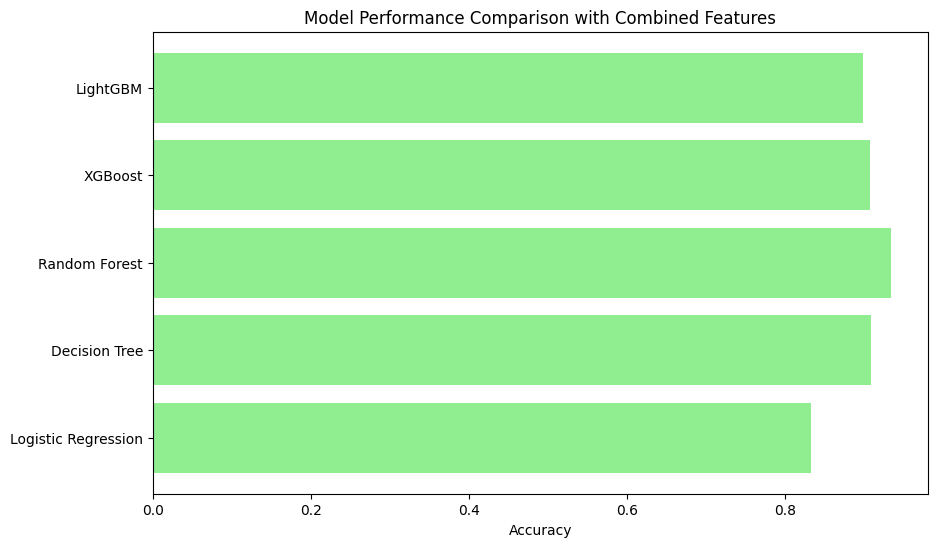

In [25]:
# Display model comparison
print("Model Comparison:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.barh(list(results.keys()), list(results.values()), color='lightgreen')
plt.xlabel('Accuracy')
plt.title('Model Performance Comparison with Combined Features')
plt.show()


Calculating Feature Importance...

Top 20 Features for Random Forest:

url_entropy: 0.1081
num_digits: 0.0861
url_length: 0.0828
TFIDF_.com/: 0.0332
TFIDF_com/: 0.0301
TFIDF_om/: 0.0293
has_suspicious_words: 0.0281
num_subdomains: 0.0254
TFIDF_php: 0.0254
TFIDF_.com: 0.0227
num_special_chars: 0.0221
TFIDF_.co: 0.0208
TFIDF_ogin: 0.0200
TFIDF_.ph: 0.0198
TFIDF_com: 0.0178
TFIDF_.php: 0.0170
TFIDF_gin: 0.0136
num_params: 0.0124
TFIDF_login: 0.0120
TFIDF_htm: 0.0120


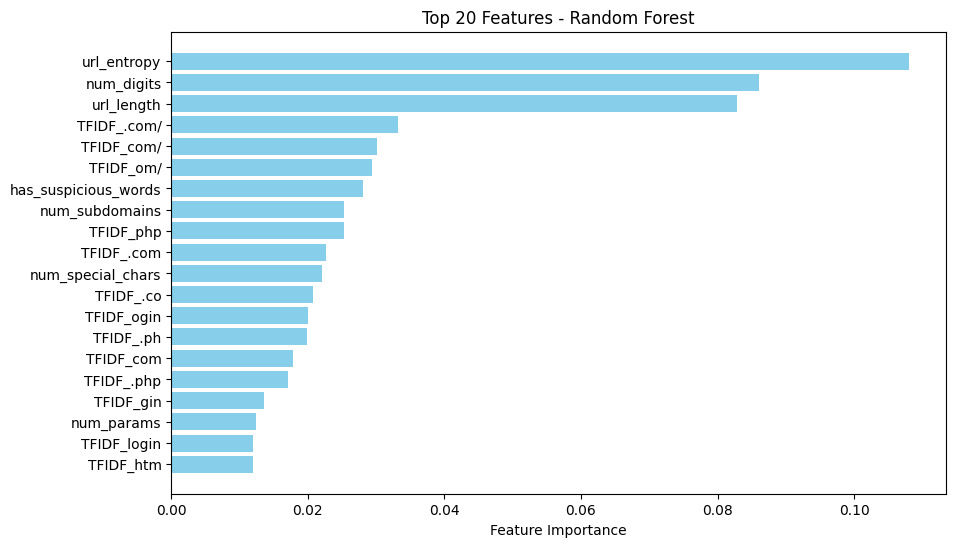


Top 20 Features for XGBoost:

has_suspicious_words: 0.1150
TFIDF_org: 0.1142
TFIDF_rg/: 0.0806
TFIDF_ogin: 0.0495
TFIDF_php: 0.0393
TFIDF_.com/: 0.0366
TFIDF_gin: 0.0358
contains_ip: 0.0310
TFIDF_org/: 0.0264
TFIDF_.org/: 0.0250
TFIDF_htm: 0.0248
TFIDF_com/: 0.0239
TFIDF_amp;: 0.0199
TFIDF_wiki: 0.0184
TFIDF_.php: 0.0168
TFIDF_html: 0.0098
TFIDF_wik: 0.0094
TFIDF_tml: 0.0094
num_digits: 0.0093
TFIDF_/in: 0.0089


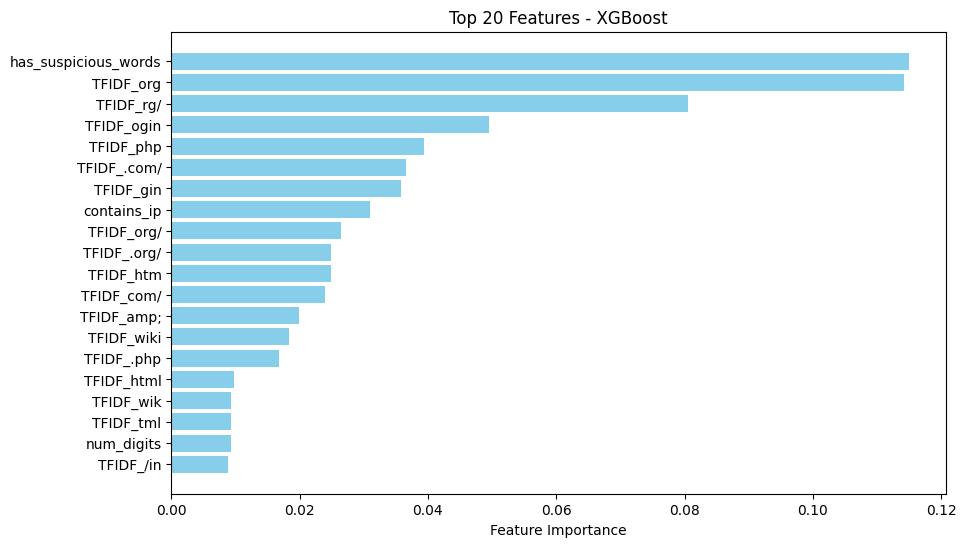


Top 20 Features for LightGBM:

num_digits: 277.0000
url_length: 221.0000
url_entropy: 149.0000
num_subdomains: 124.0000
num_special_chars: 101.0000
num_params: 87.0000
TFIDF_.com: 67.0000
TFIDF_es/: 67.0000
TFIDF_www: 64.0000
0s_in_url: 54.0000
TFIDF_/in: 49.0000
TFIDF_php: 48.0000
TFIDF_htm: 48.0000
TFIDF_id=: 46.0000
TFIDF_.co: 45.0000
TFIDF_.com/: 44.0000
TFIDF_wiki: 43.0000
TFIDF_e.c: 43.0000
TFIDF_html: 42.0000
TFIDF_ate: 41.0000


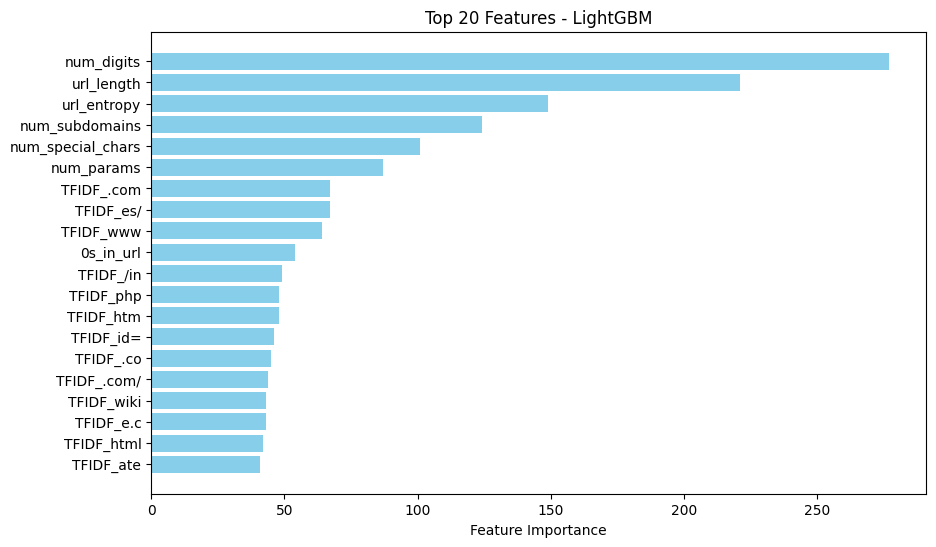

Feature Importance Analysis Complete.


In [26]:
import numpy as np

# Combine manual feature names and TF-IDF feature names
manual_feature_names = list(X_manual.columns)
tfidf_feature_names = [f"TFIDF_{feat}" for feat in tfidf_vectorizer.get_feature_names_out()]
combined_feature_names = manual_feature_names + tfidf_feature_names

# Helper function to display top features
def display_top_features(feature_importances, feature_names, top_n=20, model_name="Model"):
    indices = np.argsort(feature_importances)[::-1]  # Sort indices by importance descending
    top_features = [(feature_names[i], feature_importances[i]) for i in indices[:top_n]]

    print(f"\nTop {top_n} Features for {model_name}:\n")
    for feature, importance in top_features:
        print(f"{feature}: {importance:.4f}")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh([feature for feature, _ in top_features][::-1],
             [importance for _, importance in top_features][::-1], color='skyblue')
    plt.xlabel("Feature Importance")
    plt.title(f"Top {top_n} Features - {model_name}")
    plt.show()

# Feature importance for models
print("Calculating Feature Importance...")

# Random Forest
if "Random Forest" in models:
    rf_importances = models['Random Forest'].feature_importances_
    display_top_features(rf_importances, combined_feature_names, model_name="Random Forest")

# XGBoost
if "XGBoost" in models:
    xgb_importances = models['XGBoost'].feature_importances_
    display_top_features(xgb_importances, combined_feature_names, model_name="XGBoost")

# LightGBM
if "LightGBM" in models:
    lgb_importances = models['LightGBM'].feature_importances_
    display_top_features(lgb_importances, combined_feature_names, model_name="LightGBM")

print("Feature Importance Analysis Complete.")


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Convert sparse to dense if necessary
X_train_dense = X_train.toarray() if hasattr(X_train, 'toarray') else X_train
X_test_dense = X_test.toarray() if hasattr(X_test, 'toarray') else X_test

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4]
}

# Initialize Random Forest model
rf_model = RandomForestClassifier()

# Grid search with cross-validation (n_jobs=1 for sequential processing)
grid_search = GridSearchCV(rf_model, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_dense, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate model with best hyperparameters
best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train_dense, y_train)
y_pred = best_rf_model.predict(X_test_dense)

# Evaluation metrics
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy with Best Hyperparameters: {acc:.4f}")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  41.2s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  41.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  41.6s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.2min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.2min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  32.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.2min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  34.3s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  32.1s
[CV] END max_depth=10, min_samples_